In [67]:
# Cell 1: Install dependencies
!pip install playwright beautifulsoup4
!playwright install firefox


In [68]:
# Cell 2: Import libraries
import asyncio
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright


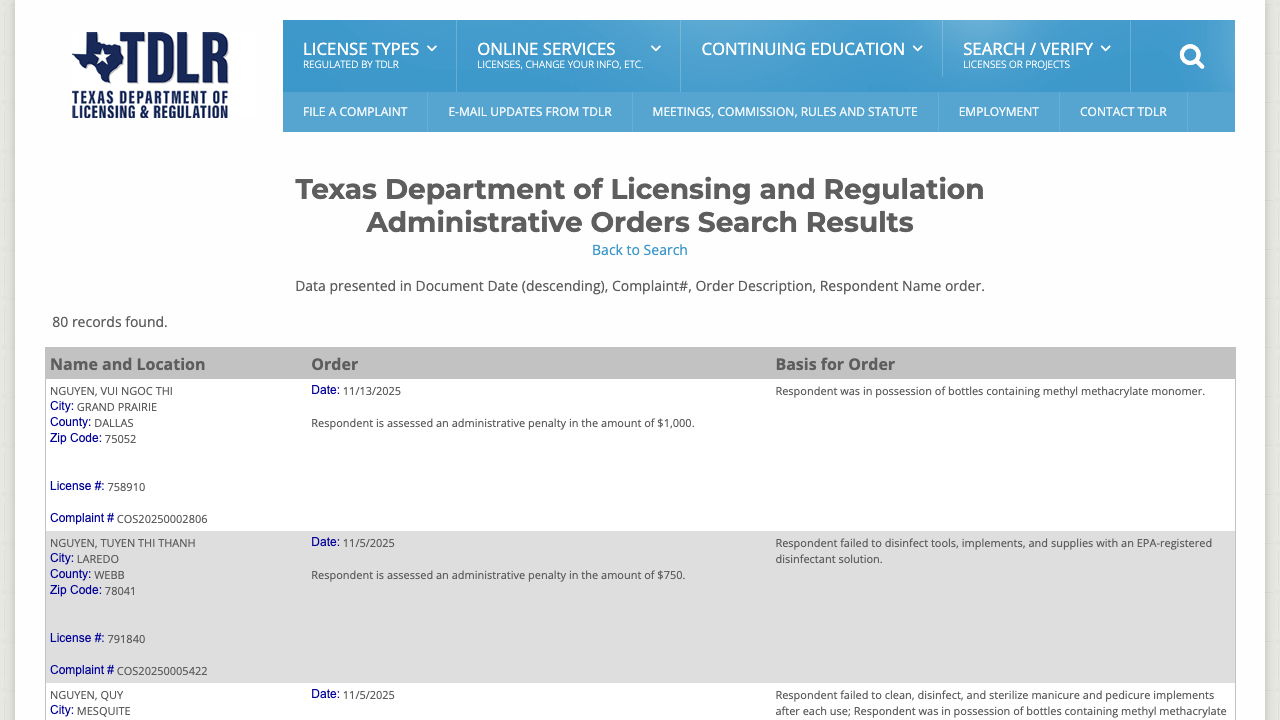

In [69]:
# Cell: Fetch NGUYEN results with Playwright
async def fetch_nguyen_results():
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        
        # Go to the search page
        await page.goto("https://www.tdlr.texas.gov/cimsfo/fosearch_results.asp", wait_until="networkidle")
        
        # Fill Last Name field
        await page.fill('#pht_lnm', "NGUYEN")
        
        # Click Search button
        await page.click('input[name="B1"]')
        
        # Wait for results page to load
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot to confirm page loaded
        screenshot = await page.screenshot()
        from IPython.display import display, Image
        display(Image(screenshot))
        
        # Get HTML of results
        html = await page.content()
        await browser.close()
        return html

# Run the async function
html = asyncio.run(fetch_nguyen_results())


In [70]:
# Cell: Robust extraction of NGUYEN rows and save CSV
from bs4 import BeautifulSoup
import pandas as pd

soup = BeautifulSoup(html, "html.parser")

rows = soup.find_all("tr")
data = []

for row in rows:
    cells = row.find_all("td")
    if len(cells) != 3:
        continue
    
    # Make sure first cell contains a name
    name_cell = cells[0].get_text(strip=True)
    if not name_cell:
        continue
    
    col1 = cells[0].get_text(separator="|").split("|")
    name = col1[0].strip()
    if "NGUYEN" not in name.upper():
        continue
    
    city = col1[2].strip() if len(col1) > 2 else ""
    county = col1[4].strip() if len(col1) > 4 else ""
    zip_code = col1[6].strip() if len(col1) > 6 else ""
    license_num = col1[8].strip() if len(col1) > 8 else ""
    complaint_num = col1[10].strip() if len(col1) > 10 else ""
    
    col2_text = cells[1].get_text(separator="|").split("|")
    date = col2_text[1].strip() if len(col2_text) > 1 else ""
    action = col2_text[2].strip() if len(col2_text) > 2 else ""
    
    violation = cells[2].get_text(strip=True)
    
    data.append({
        "Name": name,
        "City": city,
        "County": county,
        "Zip Code": zip_code,
        "License #": license_num,
        "Complaint #": complaint_num,
        "Date": date,
        "Action / Penalty": action,
        "Violation": violation
    })

# Convert to DataFrame and save CSV
df = pd.DataFrame(data)
df.to_csv("tdlr_nguyen_complaints.csv", index=False)

print(f"CSV saved! Total rows: {len(df)}")
df.head()


CSV saved! Total rows: 80


,Name,City,County,Zip Code,License #,Complaint #,Date,Action / Penalty,Violation
0,"NGUYEN, VUI NGOC THI",City:,GRAND PRAIRIE,County:,DALLAS,Zip Code:,,11/13/2025,Respondent was in possession of bottles contai...
1,"NGUYEN, TUYEN THI THANH",City:,LAREDO,County:,WEBB,Zip Code:,,11/5/2025,"Respondent failed to disinfect tools, implemen..."
2,"NGUYEN, QUY",City:,MESQUITE,County:,DALLAS,Zip Code:,,11/5/2025,"Respondent failed to clean, disinfect, and ste..."
3,"NGUYEN, NAM QUANG",City:,HARKER HEIGHTS,County:,BELL,Zip Code:,,10/30/2025,"Respondent failed to clean, disinfect, and ste..."
4,"NGUYEN, KEVIN C",City:,KYLE,County:,HAYS,Zip Code:,,10/6/2025,Respondent employed an individual as an operat...
